In [2]:
import numpy as np
from estimator import RFClassifier
from data_fns import noisy_sin_signal, butter_bandpass_filter, data_matrix
import matplotlib.pyplot as plt
import dask

In [3]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:42311 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [4]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

In [5]:
# signal
signal, label = noisy_sin_signal(f_s=2000, dur=10, f_signal=100, sig_dur=0.05, a=0.9, seed=39)

# neuron memory
delta = 0.08
N = int(delta * 2000)

X, y = data_matrix(signal, label, N)

# separate into train and test set
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

In [6]:
f = lambda M, N: bp_weights(M, N, lowcut=90, highcut=110, fs=2000)

def l_clf(clf, params, X_train, y_train, X_test, y_test):
    clf = clf(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [7]:
n_features = sorted(set(np.logspace(0, 3, 25).astype('int')))
print(n_features)

[1, 2, 3, 4, 5, 7, 10, 13, 17, 23, 31, 42, 56, 74, 100, 133, 177, 237, 316, 421, 562, 749, 1000]


In [9]:
%%time
scores = []
for n in n_features:
    params = {'width': n, 'weight_fun': f}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    scores.append(dask.compute(*lazy_results))

CPU times: user 31.1 s, sys: 22 s, total: 53.1 s
Wall time: 3min 28s


<ErrorbarContainer object of 3 artists>

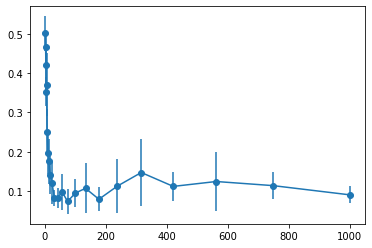

In [10]:
mean_err = 1 - np.mean(scores, axis=1)
std_err = np.std(scores, axis=1)

fig = plt.figure()
plt.errorbar(n_features, mean_err, yerr=std_err, fmt='-o')